In [7]:
import pandas as pd
import numpy as np
import gudhi as gd
from gudhi.point_cloud.timedelay import TimeDelayEmbedding
from gudhi.hera import wasserstein_distance
from gudhi.representations import PersistenceImage, Landscape, Entropy
from gudhi.representations.metrics import WassersteinDistance
import matplotlib.pyplot as plt
from matplotlib import cm
from sklearn.manifold import MDS
from sklearn.decomposition import PCA

import os
from tqdm.notebook import tqdm


#%matplotlib widget

In [8]:
datapath =".\\data\\timeseries\\good2"
filelist = os.listdir(datapath)
print(sorted(filelist))
good_labels  =sorted(filelist)
good_time_series = [np.loadtxt(os.path.join(datapath,f)) for f in sorted(filelist)]
datapath =".\\data\\timeseries\\bad2"
filelist = os.listdir(datapath)
print(sorted(filelist))
bad_labels = sorted(filelist)
bad_time_series = [np.loadtxt(os.path.join(datapath,f)) for f in sorted(filelist)]

print(good_time_series[0])

['signal05_good.txt', 'signal10_good.txt', 'signal15_good.txt', 'signal20_good.txt', 'signal25_good.txt']
['signal05_bad.txt', 'signal10_bad.txt', 'signal15_bad.txt', 'signal20_bad.txt', 'signal25_bad.txt']
[ 0.2504463   0.07998543 -0.35629045 ... -0.55235447 -0.22336272
 -0.37701057]


In [9]:
n_chunks = 100
chopped_good_ts = [[]]*len(good_time_series)
chopped_bad_ts = [[]]*len(bad_time_series)
chunks = np.array_split(range(0,len(good_time_series[0])), n_chunks)
for i in range(0,len(good_time_series)):
    chopped_good_ts[i] = np.array_split(good_time_series[i], n_chunks)
    chopped_bad_ts[i] = np.array_split(bad_time_series[i], n_chunks)

In [10]:
dim = 10
delay =14
skip = 1
good_point_clouds = []
bad_point_clouds = []

tde = TimeDelayEmbedding(dim = dim, delay=delay, skip=skip)

for i in range(0,len(good_time_series)):
    good_point_clouds.append(tde.transform(chopped_good_ts[i]))
    bad_point_clouds.append(tde.transform(chopped_bad_ts[i]))

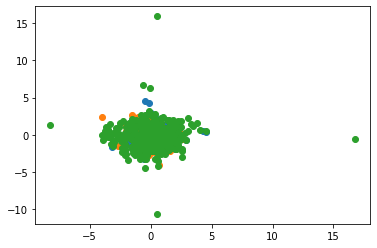

In [11]:
f,ax = plt.subplots()
ax.scatter(good_point_clouds[0][0][:,0],good_point_clouds[0][0][:,1])
ax.scatter(good_point_clouds[0][1][:,0],good_point_clouds[0][1][:,1])
ax.scatter(good_point_clouds[1][0][:,0],good_point_clouds[1][1][:,1])

In [12]:
all_pds = []
good_pds = []

for i in range(0,len(good_point_clouds)):
    to_add = []
    
    for pc in good_point_clouds[i]:
        ac = gd.RipsComplex(pc)
        st = ac.create_simplex_tree(max_dimension=2)
        st.compute_persistence()
        to_add.append(st.persistence_intervals_in_dimension(1))
        all_pds.append(st.persistence_intervals_in_dimension(1))
    good_pds.append(to_add)    
    
    #print(st.persistence_intervals_in_dimension(1)[0])

bad_pds = []

for i in range(0,len(bad_point_clouds)):
    to_add = []
    for pc in bad_point_clouds[i]:
        ac = gd.RipsComplex(pc)
        st = ac.create_simplex_tree(max_dimension=2)
        st.compute_persistence()
        to_add.append(st.persistence_intervals_in_dimension(1))
        all_pds.append(st.persistence_intervals_in_dimension(1))
    bad_pds.append(to_add)

In [8]:
len(all_pds)

1000

In [26]:

pi = Landscape(num_landscapes=100, resolution=100)
#pi=Entropy()
#pi=PersistenceImage()

pi.fit(all_pds)

good_pis = []
for i in range(0,len(good_pds)):
    good_pis.append(pi.transform(good_pds[i]))
bad_pis = []
for i in range(0,len(bad_pds)):
    bad_pis.append(pi.transform(bad_pds[i]))

#plt.matshow(good_pis[0][0].reshape(pi.resolution))

In [27]:
good_pis[0][0].shape

(10000,)

In [28]:
pi_dist_matrix = np.zeros((len(good_pds),n_chunks))
for j in range(0,len(good_time_series)):
    for i in range(0,n_chunks):
        diff = np.linalg.norm(good_pis[j][i]-bad_pis[j][i])
        #print(j,i,diff)
        pi_dist_matrix[j][i] = diff

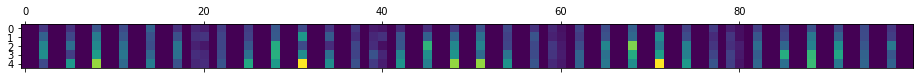

In [29]:
plt.matshow(pi_dist_matrix)

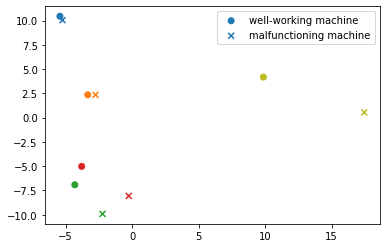

In [30]:
good_concat_vectors = [np.concatenate(good_pis[i]) for i in range(0,len(good_pis))]
bad_concat_vectors = [np.concatenate(bad_pis[i]) for i in range(0,len(bad_pis))]
mds = PCA(n_components=2)
emb =mds.fit_transform(np.concatenate([good_concat_vectors,bad_concat_vectors]))
f,ax = plt.subplots()
colors = ["tab:blue","tab:orange", "tab:green", "tab:red","tab:olive"]
ax.scatter(emb[:5,0],emb[:5,1], marker = "o", c= colors, label="well-working machine")
ax.scatter(emb[5:,0],emb[5:,1], marker = "x", c=colors, label="malfunctioning machine")
ax.legend()
plt.show()

In [68]:
## Wasserstein computation is horribly slow, do not execute this cell
outlier_chunks = []
dist_matrix = np.zeros((len(good_pds),n_chunks))
for j in range(0,len(good_pds)):
    print(j)
    for i in tqdm(range(0,n_chunks)):
        dist = gd.hera.wasserstein_distance(good_pds[j][i],bad_pds[j][i], internal_p = 2, order = 2, delta= 0.1)
        dist_matrix[j][i] = dist
        #if dist > 0:
            #print(i)
            #print(dist)
            #print(chunks[i])
            #outlier_chunks.append(i)

0



1


In [ ]:
plt.matshow(dist_matrix)

In [11]:
dist_matrix[:,-6]

array([0.08797056, 0.08797056, 0.08797056, 0.08797056, 0.08797056])

In [8]:
ts_dist_matrix = np.zeros((len(good_pds),n_chunks))
for j in range(0,len(good_time_series)):
    for i in range(0,n_chunks):
        diff = chopped_good_ts[j][i]-chopped_bad_ts[j][i]
        #print(j,i,diff)
        ts_dist_matrix[j][i] = np.abs(np.mean(diff))

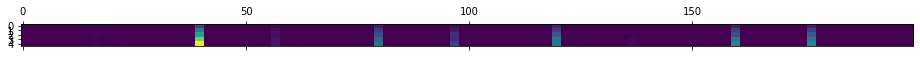

In [9]:
plt.matshow(ts_dist_matrix)